<a href="https://colab.research.google.com/github/bjamin5/Deep-Learning-Coursework/blob/main/Projects/Cancer_Cell_Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<a href="https://colab.research.google.com/github/wingated/cs474_labs_f2019/blob/master/DL_Lab4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Cancer Detection

## Objective
* To build a dense prediction model
* To begin reading current papers in DNN research

## Deliverable
For this lab, you will turn in a notebook that describes your efforts at creating
a pytorch radiologist. Your final deliverable is a notebook that has (1) a deep network,
(2) method of calculating accuracy, 
(3) images that show the dense prediction produced by your network on the pos_test_000072.png image (index 172 in the validation dataset).
This is an image in the test set that your network will not have seen before.
This image, and the ground truth labeling, is shown below.
(And is contained in the downloadable dataset below).

![](http://liftothers.org/dokuwiki/lib/exe/fetch.php?w=200&tok=a8ac31&media=cs501r_f2016:pos_test_000072_output.png)
<img src="http://liftothers.org/dokuwiki/lib/exe/fetch.php?media=cs501r_f2016:pos_test_000072.png" width="200">


## Data set
The data is given as a set of 1024×1024 PNG images. Each input image (in 
the ```inputs``` directory) is an RGB image of a section of tissue,
and there a file with the same name (in the ```outputs``` directory) 
that has a dense labeling of whether or not a section of tissue is cancerous
(white pixels mean “cancerous”, while black pixels mean “not cancerous”).

The data has been pre-split for you into test and training splits.
Filenames also reflect whether or not the image has any cancer at all 
(files starting with ```pos_``` have some cancerous pixels, while files 
starting with ```neg_``` have no cancer anywhere).
All of the data is hand-labeled, so the dataset is not very large.
That means that overfitting is a real possibility.

## Description
For a video including some tips and tricks that can help with this lab: [https://youtu.be/Ms19kgK_D8w](https://youtu.be/Ms19kgK_D8w)
For this lab, you will implement a virtual radiologist.
You are given images of possibly cancerous tissue samples, 
and you must build a detector that identifies where in the tissue cancer may reside.

---

https://youtu.be/Ms19kgK_D8w

### Part 1
Implement a dense predictor

In previous labs and lectures, we have talked about DNNs that classify an 
entire image as a single class. Here, however, we are interested in a more nuanced classification: 
given an input image, we would like to identify each pixel that is possibly cancerous. 
That means that instead of a single output, your network should output an “image”, 
where each output pixel of your network represents the probability that a pixel is cancerous.

___

Implement your network topology

Use the “Deep Convolution U-Net” from this paper: [(U-Net: Convolutional Networks for Biomedical Image Segmentation)](https://arxiv.org/pdf/1505.04597.pdf) 

![(Figure 1)](https://lh3.googleusercontent.com/qnHiB3B2KRxC3NjiSDtY08_DgDGTDsHcO6PP53oNRuct-p2QXCR-gyLkDveO850F2tTAhIOPC5Ha06NP9xq1JPsVAHlQ5UXA5V-9zkUrJHGhP_MNHFoRGnjBz1vn1p8P2rMWhlAb6HQ=w2400)

You should use existing pytorch functions (not your own Conv2D module), such as ```nn.Conv2d``` and ```nn.CrossEntropyLoss```;
you will also need the pytorch function ```torch.cat``` and ```nn.ConvTranspose2d```

```torch.cat``` allows you to concatenate tensors.
```nn.ConvTranspose2d``` is the opposite of ```nn.Conv2d```.
It is used to bring an image from low res to higher res.
[This blog](https://towardsdatascience.com/up-sampling-with-transposed-convolution-9ae4f2df52d0) should help you understand this function in detail.

You can simplify the implementation of this lab by padding the feature maps as they pass through each convolution. This will make the concatenation process easier, though this is technically a departure from the cropping technique outlined in the orginal U-Net paper. 

Note that the simplest network you could implement (with all the desired properties)
is just a single convolution layer with two filters and no relu! 
Why is that? (of course it wouldn't work very well!)

**TODO:**

**DONE:**

* Understand the U-Net architecture
* Understand concatenation of inputs from multiple prior layers
* Understand ConvTranspose
* Answer Question / Reflect on simplest network with the desired properties


In [ ]:
!pip3 install torch
!pip3 install torchvision
!pip3 install tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from torchvision import transforms, utils, datasets
from tqdm import tqdm
from torch.nn.parameter import Parameter
import pdb
import torchvision
import os
import gzip
import tarfile
import gc
from IPython.core.ultratb import AutoFormattedTB
__ITB__ = AutoFormattedTB(mode = 'Verbose',color_scheme='LightBg', tb_offset = 1)

assert torch.cuda.is_available(), "You need to request a GPU from Runtime > Change Runtime"

WARNING: You may run into an error that says "RuntimeError: CUDA out of memory."

In this case, the memory required for your batch is larger than what the GPU is capable of. You can solve this problem by adjusting the image size or the batch size and then restarting the runtime. 

In [ ]:
class CancerDataset(Dataset):
  def __init__(self, root, download=True, size=512, train=True):
    if download and not os.path.exists(os.path.join(root, 'cancer_data')):
      datasets.utils.download_url('http://liftothers.org/cancer_data.tar.gz', root, 'cancer_data.tar.gz', None)
      self.extract_gzip(os.path.join(root, 'cancer_data.tar.gz'))
      self.extract_tar(os.path.join(root, 'cancer_data.tar'))
    
    postfix = 'train' if train else 'test'
    root = os.path.join(root, 'cancer_data', 'cancer_data')
    self.dataset_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'inputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))
    self.label_folder = torchvision.datasets.ImageFolder(os.path.join(root, 'outputs_' + postfix) ,transform = transforms.Compose([transforms.Resize(size),transforms.ToTensor()]))

  @staticmethod
  def extract_gzip(gzip_path, remove_finished=False):
    print('Extracting {}'.format(gzip_path))
    with open(gzip_path.replace('.gz', ''), 'wb') as out_f, gzip.GzipFile(gzip_path) as zip_f:
      out_f.write(zip_f.read())
    if remove_finished:
      os.unlink(gzip_path)
  
  @staticmethod
  def extract_tar(tar_path):
    print('Untarring {}'.format(tar_path))
    z = tarfile.TarFile(tar_path)
    z.extractall(tar_path.replace('.tar', ''))

  def __getitem__(self,index):
    img = self.dataset_folder[index]
    label = self.label_folder[index]
    return img[0],label[0][0]
  
  def __len__(self):
    return len(self.dataset_folder)

In [ ]:
# Test input / output sizes of the Conv block
test = conv_block(1,64, pad=1)
x = torch.randn(1, 1, 512, 512)
test(x).shape

torch.Size([1, 64, 512, 512])

In [ ]:
# Use the output of one network in two places(convolution and maxpooling),
# use the built-in batch normalization and dropout layer.

class conv_block(nn.Module):
    def __init__(self, in_channels, out_channels, pad=0):
        super().__init__()
        # two conv. operations, one that doubles the number of channels from
        # in_channels to out_channels and another that goes from out_channels
        # to out_channels. Both are 2D convs with kernel = 3, padding = 0, and relu
        self.conv1 = nn.Conv2d(in_channels, out_channels, padding=pad, kernel_size=3)
        self.relu = nn.ReLU()
        self.conv2 = nn.Conv2d(out_channels, out_channels, padding=pad, kernel_size=3)
    
    def forward(self, x):
        x = self.conv1(x)
        x = self.relu(x)
        x = self.conv2(x)
        x = self.relu(x)
        return x

class UNet(nn.Module):
  def __init__(self): #, n_channels, n_classes): # CancerDetection constructor
    # You always need to use super to call nn.Module's init function when creating a class that inherits nn.Module.
    super(UNet, self).__init__()
    # c, h, w = x.size()
    output_dim = 2

    # down layers
    self.dlayer1 = conv_block(3, 64, pad=1)
    self.dlayer2 = conv_block(64, 128, pad=1)
    self.dlayer3 = conv_block(128, 256, pad=1)
    self.dlayer4 = conv_block(256, 512, pad=1)

    self.dlayer5 = conv_block(512, 1024, pad=1)

    # up layers
    self.ulayer4 = conv_block(1024, 512, pad=1)
    self.ulayer3 = conv_block(512, 256, pad=1)
    self.ulayer2 = conv_block(256, 128, pad=1)
    self.ulayer1 = conv_block(128, 64, pad=1)
    self.out_layer = nn.Conv2d(64, output_dim, kernel_size=1)
    self.pool = nn.MaxPool2d((2,2))

    self.upConv4 = nn.ConvTranspose2d(1024, 512, (2,2), stride=2)
    self.upConv3 = nn.ConvTranspose2d(512,256, (2,2), stride=2)
    self.upConv2 = nn.ConvTranspose2d(256, 128, (2,2), stride=2)
    self.upConv1 = nn.ConvTranspose2d(128, 64, (2,2), stride=2)

  def forward(self, input): # nn.Module sets up a hook that calls forward when you "call" the module object: net(x) calls net.forward(x)
    # pdb.set_trace()
    o1 = self.dlayer1(input)
    o2 = self.dlayer2(self.pool(o1))
    o3 = self.dlayer3(self.pool(o2))
    o4 = self.dlayer4(self.pool(o3))
    o5 = self.dlayer5(self.pool(o4))

    # pdb.set_trace()
    up_o4 = self.ulayer4(torch.cat((o4, self.upConv4(o5)), dim=1))
    up_o3 = self.ulayer3(torch.cat((o3, self.upConv3(up_o4)), dim=1))
    up_o2 = self.ulayer2(torch.cat((o2, self.upConv2(up_o3)), dim=1))
    up_o1 = self.ulayer1(torch.cat((o1, self.upConv1(up_o2)), dim=1))
    out = self.out_layer(up_o1)

    return out



In [ ]:
def Cancer_Detector(total_epochs=8):
  try:
    #dataset
    train_dataset = CancerDataset('/tmp/fashionmnist', size=256, train=True)
    val_dataset = CancerDataset('/tmp/fashionmnist', size=256, train=False)

    # Instantiate your data loaders
    train_loader = DataLoader(train_dataset, batch_size=5, pin_memory=True, shuffle=True) 
    val_loader = DataLoader(val_dataset, batch_size=5) # n batches x c channels x h height x w width

    # Instantiate your model and loss and optimizer functions
    model = UNet() 
    model.cuda()

    #Optimizer is the thing that takes the step to make the model better
    objective = nn.CrossEntropyLoss() #MSE->classification prob...etc
    optimizer = optim.Adam(model.parameters(), lr=1e-4)

    gc.collect()
    # print(torch.cuda.memory_allocated() / 1e9)
    
    # Get value
    im_172_list = [] 
    im_172_x, im_172_y = val_dataset[172]
    # pdb.set_trace()
    torch.save(im_172_y, './saved/im_172_y.pt')
    # Call your model, figure out loss and accuracy
    for epoch in range(total_epochs):
      if epoch == total_epochs:
        save_model(model)
        torch.save(im_172_list, './saved/im_172_list.pt')
        return im_172_list, im_172_y

      gc.collect()
      
      # to plot get rid of the dims we don't care about
      
      for batch, (x, y_truth) in enumerate(train_loader):
        x, y_truth = x.cuda(), y_truth.cuda() 

        optimizer.zero_grad()
        y_hat = model(x) 


        # Preprocess y_hat to be 0's and 1's (5, 1, 512, 512)
        # argmax(y_hat, dim=0)

        #(5, 2, 512, 512)      (5, 1, 512, 512)
        # pdb.set_trace()
        loss = objective(y_hat, y_truth.long()) 
        loss.backward() 
          
        # Training set accuracy after each batch

        # pdb.set_trace()
        preds = torch.argmax(y_hat, dim=1) # Returns index of where max is 
        # preds = preds.indices.reshape((y_truth.shape)) # y_truth.shape = (5) not always though because batch size can differ
        correct = preds == y_truth
        # correct is (batch x val)
        if batch % 100 == 0:
          losses_train.append((len(losses_train), loss.item())) # store loss
          accuracy_train.append((len(accuracy_train), torch.sum(correct).item() / (correct.shape[0] * correct.shape[1] * correct.shape[2])))
        # pdb.set_trace()

        #loop.set_description('epoch:{}, batch:{}, loss:{:.4f}, accuracy:{:.3f}'.format(epoch, batch, loss.item(), accuracy))
        #loop.update(1)
        optimizer.step() # Taking that step based on the gradient we computed

        # Validation Loop - run it more than just every epoch
        if batch % 100 == 0:
          # this gives me all of the losses by passing in my x's and comparing them to my y's
          # returns tensors so to get the first element in the tensor call item()
          # then compute the mean of the losses

          # Would work as well
          # val = np.mean([objective(model(x.cuda()), y.long().cuda()).item()
          #               for x, y in val_loader])
          # losses_val.append((len(losses_val), val)) 

          # Calc Accuracy after each batch
          loss = 0
          accuracy = 0
          with torch.no_grad():
            model.eval()
            # Calc IM 172
            x = im_172_x.unsqueeze(0).cuda() # Get right dims
            pred = model(x)
            im_172_list.append(pred)

            # Calc Validation Loss and Accuracy
            correct = 0
            total = 0
            outputs = 0
            loss_list = []
            accuracy_list = []
            for images, labels in val_loader:
              images = images.cuda()
              labels = labels.cuda()

              outputs = model(images)

              # calc loss and accuracy  for current batch
              loss = loss_list.append(objective(model(images), labels.long()).item())

              preds = torch.argmax(outputs, dim=1) # Returns index of where max is 

              # preds = preds.indices.reshape((y_truth.shape)) # y_truth.shape = (5) not always though because batch size can differ
              correct = preds == y_truth
              # correct is (batch x val)
              accuracy_list.append(torch.sum(correct).item() / (correct.shape[0] * correct.shape[1] * correct.shape[2])) 

            # pdb.set_trace():
            accuracy = np.mean(accuracy_list)
            loss = np.mean(loss_list)
            losses_val.append((len(losses_val), loss))
            accuracy_val.append((len(accuracy_val), accuracy)) # Make first term be length of batches so it graphs good with the training accuracies
          mem = torch.cuda.memory_allocated(0) / 1e9
          # pdb.set_trace()
          print('epoch:{}, batch:{}, loss:{:.4f}, accuracy:{:.3f}, mem:{:.3f}'.format(epoch, batch, loss.item(),100 * accuracy, mem))
          model.train()
        
  except:
    __ITB__() # prints out the excecption and traceback
  return im_172_list, im_172_y
    

In [ ]:
print(torch.cuda.memory_allocated(0) / 1e9) # In gigabytes

1.848250368


In [ ]:
losses_val = []
accuracy_val = []

losses_train = []
accuracy_train = []
im_172_list = []
im_172_y = None

im172_backup, im172_y_backup = Cancer_Detector()

epoch:0, batch:0, loss:0.7071, accuracy:1.466, mem:0.665
epoch:0, batch:100, loss:0.3466, accuracy:85.043, mem:0.666
epoch:0, batch:200, loss:0.3232, accuracy:98.158, mem:0.667
epoch:1, batch:0, loss:0.2658, accuracy:82.873, mem:0.668
epoch:1, batch:100, loss:0.2886, accuracy:77.935, mem:0.669
epoch:1, batch:200, loss:0.2273, accuracy:83.700, mem:0.669
epoch:2, batch:0, loss:0.2171, accuracy:84.753, mem:0.669
epoch:2, batch:100, loss:0.2804, accuracy:90.191, mem:0.669
epoch:2, batch:200, loss:0.2159, accuracy:75.682, mem:0.670
epoch:3, batch:0, loss:0.2612, accuracy:76.045, mem:0.670
epoch:3, batch:100, loss:0.2076, accuracy:84.411, mem:0.671
epoch:3, batch:200, loss:0.2134, accuracy:70.932, mem:0.672
epoch:4, batch:0, loss:0.2542, accuracy:83.252, mem:0.673
epoch:4, batch:100, loss:0.1979, accuracy:90.329, mem:0.673
epoch:4, batch:200, loss:0.2524, accuracy:59.595, mem:0.674
epoch:5, batch:0, loss:0.2336, accuracy:48.439, mem:0.674
epoch:5, batch:100, loss:0.2057, accuracy:81.534, mem


___

### Part 2

Plot performance over time

Please generate two plots:

 One that shows loss on the training and validation set as a function of training time. 

 One that shows accuracy on the training and validation set as a function of training time. 

 Make sure your axes are labeled!

**TODO:**

**DONE:**

* Plot training/validation loss as function of training time (not epochs)
* Plot training/validation accuracy as function of training time (not epochs)



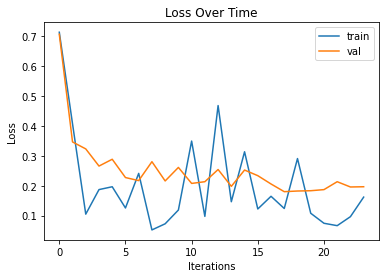

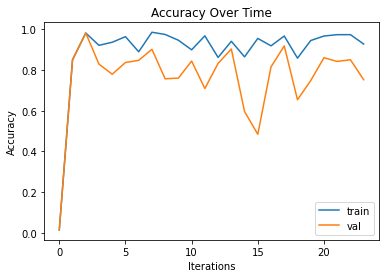

In [ ]:
# Plot training and validation loss for Xe initialization
batch, values = zip(*losses_val)
batch2, values2 = zip(*losses_train)

plt.figure(1)
plt.plot(batch2, values2, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Loss')
plt.xlabel('Iterations')
plt.title('Loss Over Time')
plt.legend()

# Plot training and validation accuracy for Xe initialization

plt.figure(2)
batch, values = zip(*accuracy_val)
batch2, values2 = zip(*accuracy_train)

plt.plot(batch2, values2, label='train')
plt.plot(batch, values, label='val')
plt.ylabel('Accuracy')
plt.xlabel('Iterations')
plt.title('Accuracy Over Time')
plt.legend()
plt.show()


**NOTE:**

Guessing that the pixel is not cancerous every single time will give you an accuracy of ~ 85%.


___

### Part 3

Generate at least 5 predictions on the pos_test_000072.png image and display them as images. These predictions should be made at a reasonable interval (e.g. every epoch). 

You can load this image from the file pos_test_000072.png, or you can get it from the dataset object. It is item 172 of the validation dataset.
You can print both the data instance (x) and the ground-truth label (y_hat) to see how well your network predicts on that instance.

To do this, calculate the output of your trained network on the pos_test_000072.png image,
then make a hard decision (cancerous/not-cancerous) for each pixel.
The resulting image should be black-and-white, where white pixels represent areas
the network considers cancerous.



In [ ]:
# Save the model
def save_model(model, path='./saved/unet.pt'):
    torch.save(model.load_state_dict(), path)
    return

# Load the model
def load_model(model, path='./saved/unet.pt'):
    model.load_state_dict(torch.load(path))
    model.eval() 


In [ ]:
list_copy = im172_backup.copy()

In [ ]:
im172_backup, im172_y_backup

In [ ]:
im1 = list_copy[2]
im2 = list_copy[5]
im3 = list_copy[7]
im4 = list_copy[10]
im5 = list_copy[13]
im7 = list_copy[23]

torch.Size([1, 2, 256, 256])
torch.Size([2, 256, 256])
(256, 256)


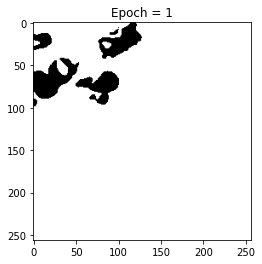

In [ ]:
print(im1.shape)
im1 = im1.squeeze(0)
print(im1.shape)
im1 = im1.permute(1,2,0)
# pdb.set_trace()

im1 = torch.argmax(im1, dim=2)

im1 = im1.cpu().numpy()

print(im1.shape)
plt.imshow(im1, cmap='binary')
plt.title('Epoch = 1')
plt.show()

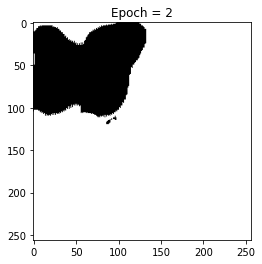

In [ ]:
im2 = im2.squeeze(0)
im2 = im2.permute(1,2,0)
im2 = torch.argmax(im2, dim=2)
im2 = im2.cpu().numpy()
plt.imshow(im2, cmap='binary')
plt.title('Epoch = 2')
plt.show()

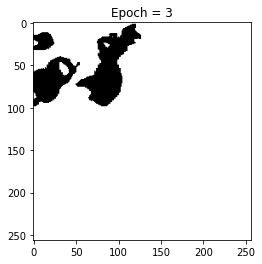

In [ ]:
im3 = im3.squeeze(0)
im3 = im3.permute(1,2,0)
im3 = torch.argmax(im3, dim=2)
im3 = im3.cpu().numpy()
plt.imshow(im3, cmap='binary')
plt.title('Epoch = 3')
plt.show()

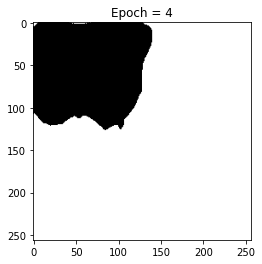

In [ ]:
im4 = im4.squeeze(0)
im4 = im4.permute(1,2,0)
im4 = torch.argmax(im4, dim=2)
im4 = im4.cpu().numpy()
plt.imshow(im4, cmap='binary')
plt.title('Epoch = 4')
plt.show()

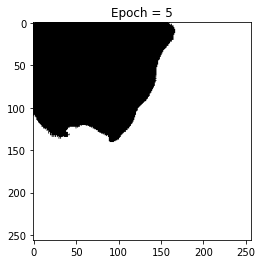

In [ ]:
im5 = im5.squeeze(0)
im5 = im5.permute(1,2,0)
im5 = torch.argmax(im5, dim=2)
im5 = im5.cpu().numpy()
plt.imshow(im5, cmap='binary')
plt.title('Epoch = 5')
plt.show()

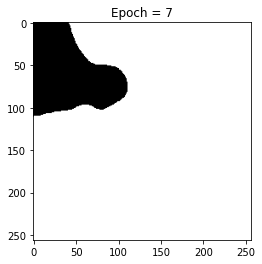

In [ ]:
im7 = im7.squeeze(0)
im7 = im7.permute(1,2,0)
im7 = torch.argmax(im7, dim=2)
im7 = im7.cpu().numpy()
plt.imshow(im7, cmap='binary')
plt.title('Epoch = 7')
plt.show()

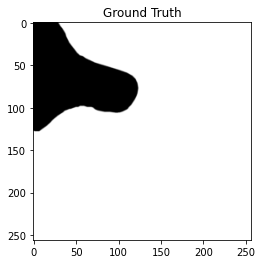

In [ ]:
im = torch.load('./saved/im_172_y.pt')
plt.imshow(im, cmap='binary')
plt.title('Ground Truth')
plt.show()

###########################Notes

In [ ]:
# Number of Parameters in 

!pip -vvv install prettyTable
from prettytable import PrettyTable

def count_parameters(model):
  table = PrettyTable(["Modules", "Parameters"])
  total_params = 0
  for name, parameter in model.named_parameters():
    if not parameter.requires_grad: continue
    param = parameter.numel() # returns the total number of elements in the input tensor
    table.add_row([name, param])
    total_params+=param
  print(table)
  print(f"Total trainable params: {total_params}")
  return total_params

test_model = UNet()

count_parameters(test_model)

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

31031810